In [1]:
###混合模型=自编码+分类器--
#https://www.kaggle.com/code/ayushkumar1603/credit-card-fraud-detection-with-99-accuracy#AUTOENCODER-MODEL
#creditcard_2023.csv
#Class
#0    284315
#1    284315
##变分自编码模型
#-https://www.kaggle.com/code/hone5com/fraud-detection-with-variational-autoencoder

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from torch.utils.data import DataLoader, TensorDataset

# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Load and preprocess the data
raw_data = pd.read_csv("D:/Credit Card Fraud Detection/creditcard.csv")
data, data_test = train_test_split(raw_data, test_size=0.25)
print(data.shape)#训练数据75%
print(data_test.shape)#测试数据

# Data preprocessing
data["Time"] = data["Time"] / 3600 % 24
data["Amount"] = np.log(data["Amount"] + 1)
data_test["Time"] = data_test["Time"] / 3600 % 24
data_test["Amount"] = np.log(data_test["Amount"] + 1)

(213605, 31)
(71202, 31)


In [12]:
print("Data unique values and counts:")
print(data['Class'].value_counts())

print("\nData Test unique values and counts:")
print(data_test['Class'].value_counts())

Data unique values and counts:
Class
0    213233
1       372
Name: count, dtype: int64

Data Test unique values and counts:
Class
0    71082
1      120
Name: count, dtype: int64


In [13]:
# VAE Loss Function (MSE + KL Divergence)
def vae_loss(x, reconstructed_x, mean, log_var):
    reconstruction_loss = F.mse_loss(reconstructed_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reconstruction_loss + kl_divergence

# 将 Pandas 数据转化为 PyTorch Tensor
x = torch.tensor(data.drop(["Class"], axis=1).values, dtype=torch.float32)
y = torch.tensor(data["Class"].values, dtype=torch.long)

# Hyperparameters
original_dim = x.shape[1]
latent_dim = 2
intermediary_dims1 = 20
intermediary_dims2 = 10
intermediary_dims3 = 8
batch_size = 128
max_epochs = 1000
# Preparing the data for PyTorch
# 根据目标标签划分正常和欺诈样本
x_norm = x[y == 0]
x_fraud = x[y == 1]

# 从正常样本中随机抽取 100,000 个样本
x_norm_sample = x_norm[torch.randint(0, x_norm.shape[0], (100000,))]

# 将正常样本分割为训练集和验证集（80%/20%）
x_norm_train_sample, x_norm_val_sample = train_test_split(x_norm_sample.numpy(), test_size=0.2)

# 转换回 PyTorch Tensor
x_norm_train_sample = torch.tensor(x_norm_train_sample, dtype=torch.float32)
x_norm_val_sample = torch.tensor(x_norm_val_sample, dtype=torch.float32)

# 创建 DataLoader 用于训练和验证
train_dataset = TensorDataset(x_norm_train_sample)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(x_norm_val_sample)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# ROC curve
def reconstruction_log_prob(eval_samples):
    model.eval()
    with torch.no_grad():
        mean, log_var = model.encoder(eval_samples)
        z = model.reparameterize(mean, log_var)
        reconstructed_samples = model.decoder(z)
        log_prob = -F.mse_loss(reconstructed_samples, eval_samples, reduction='none').sum(dim=1)
    return log_prob

from sklearn.metrics import precision_score

# 计算precision@k
def evaluate_precision_at_k(model, test_data, test_labels, k=100):
    # 确保模型处于评估模式
    model.eval()
    
    # 计算重建误差（或对数概率）
    reconstruction_errors = reconstruction_log_prob(test_data)  # 重建误差是一个负值，较小的值表示更好的重构
    
    # 计算误差的排序索引
    sorted_indices = np.argsort(reconstruction_errors)
    
    # 选择前k个最相关的样本
    top_k_indices = sorted_indices[:k]
    
    # 获取前k个预测标签
    top_k_labels = test_labels[top_k_indices]
    
    # 计算precision@k
    # 这里假设标签是二分类的，相关标签为1，非相关标签为0
    precision_at_k = np.sum(top_k_labels == 1) / k  # 计算相关标签的比例
    return precision_at_k

In [4]:
# VAE Encoder
class VAEEncoder(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim):
        super(VAEEncoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(input_dim, intermediary_dims1),
            nn.ReLU(),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            nn.ReLU(),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            nn.ReLU()
        )
        self.mean = nn.Linear(intermediary_dims3, latent_dim)
        self.log_var = nn.Linear(intermediary_dims3, latent_dim)
    
    def forward(self, x):
        x = self.fc_layers(x)
        mean = self.mean(x)
        log_var = self.log_var(x)
        return mean, log_var

# VAE Decoder
class VAEDecoder(nn.Module):
    def __init__(self, latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim):
        super(VAEDecoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(latent_dim, intermediary_dims1),
            nn.ReLU(),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            nn.ReLU(),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            nn.ReLU()
        )
        self.output_layer = nn.Linear(intermediary_dims3, output_dim)
    
    def forward(self, z):
        x = self.fc_layers(z)
        return self.output_layer(x)

# VAE Model combining the Encoder and Decoder
class VAE(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim, output_dim):
        super(VAE, self).__init__()
        self.encoder = VAEEncoder(input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim)
        self.decoder = VAEDecoder(latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim)
    
    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterize(mean, log_var)
        reconstructed_x = self.decoder(z)
        return reconstructed_x, mean, log_var


# Initialize model, optimizer, and loss function
model = VAE(input_dim=original_dim, intermediary_dims1=intermediary_dims1, intermediary_dims2=intermediary_dims2,
            intermediary_dims3=intermediary_dims3, latent_dim=latent_dim, output_dim=original_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch 0/1000, Training Loss: 10207.188096875, Validation Loss: 4670.417705948945
Epoch 20/1000, Training Loss: 3574.118987109375, Validation Loss: 3532.6845905279656
Epoch 40/1000, Training Loss: 3512.38190078125, Validation Loss: 3467.110940143561
Epoch 60/1000, Training Loss: 3459.8476875, Validation Loss: 3415.690934296626
Epoch 80/1000, Training Loss: 3385.966748046875, Validation Loss: 3343.0929351612263
Epoch 100/1000, Training Loss: 3328.535420703125, Validation Loss: 3302.267410181131
Epoch 120/1000, Training Loss: 3308.022331640625, Validation Loss: 3273.321134336435
Epoch 140/1000, Training Loss: 3292.88386953125, Validation Loss: 3250.759124172721
Epoch 160/1000, Training Loss: 3283.645216796875, Validation Loss: 3248.8070254963673
Epoch 180/1000, Training Loss: 3278.770938671875, Validation Loss: 3246.92905771049
Epoch 200/1000, Training Loss: 3277.09306484375, Validation Loss: 3252.207507868481
Epoch 220/1000, Training Loss: 3303.521440625, Validation Loss: 3289.2061184439

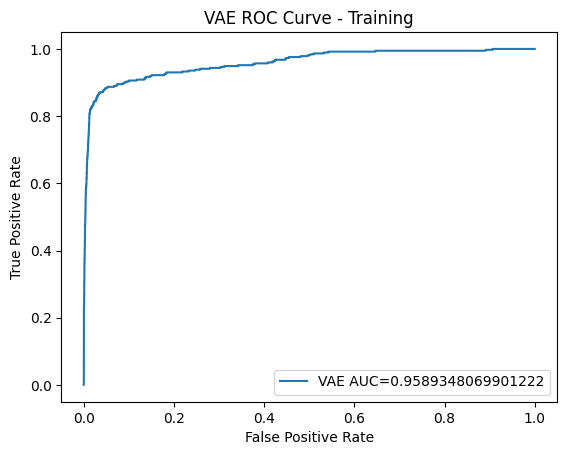

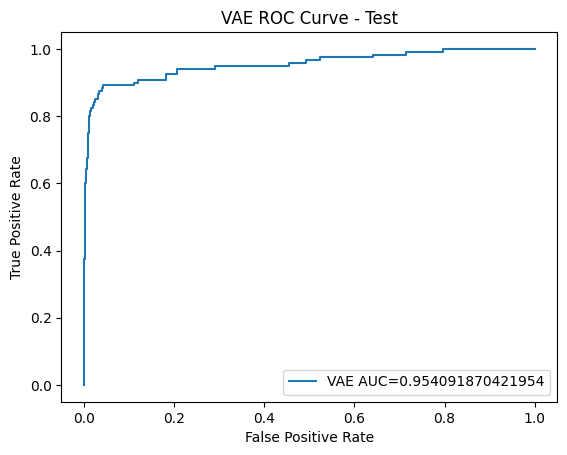

Precision@100: 0.35


In [5]:
# Training loop
for epoch in range(max_epochs):
    model.train()
    running_loss = 0.0
    for data in train_loader:
        optimizer.zero_grad()
        data = data[0]  # data is a tuple, we need to extract the tensor
        reconstructed_data, mean, log_var = model(data)
        loss = vae_loss(data, reconstructed_data, mean, log_var)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            data = data[0]
            reconstructed_data, mean, log_var = model(data)
            loss = vae_loss(data, reconstructed_data, mean, log_var)
            val_loss += loss.item()
    
    if epoch % 20 == 0:
        print(f"Epoch {epoch}/{max_epochs}, Training Loss: {running_loss/len(train_loader)}, Validation Loss: {val_loss/len(val_loader)}")

# Calculate log-probabilities for the training data
x_log_prob = reconstruction_log_prob(x)
fpr, tpr, _ = roc_curve(y.numpy(), -x_log_prob.numpy())
auc = roc_auc_score(y.numpy(), -x_log_prob.numpy())

plt.plot(fpr, tpr, label="VAE AUC=" + str(auc))
plt.title('VAE ROC Curve - Training')
plt.ylabel('True Positive Rate')
plt.xlabel("False Positive Rate")
plt.legend(loc='best')
plt.show()

# Test data evaluation
X_test_tensor = torch.tensor(data_test.drop(['Class'], axis=1).values, dtype=torch.float32)
test_y = data_test["Class"].values

# Calculate log-probabilities for the test data
x_test_log_prob = reconstruction_log_prob(X_test_tensor)
fpr, tpr, _ = roc_curve(test_y, -x_test_log_prob.numpy())
auc = roc_auc_score(test_y, -x_test_log_prob.numpy())

plt.plot(fpr, tpr, label="VAE AUC=" + str(auc))
plt.title('VAE ROC Curve - Test')
plt.ylabel('True Positive Rate')
plt.xlabel("False Positive Rate")
plt.legend(loc='best')
plt.show()

# 计算precision@100
precision_at_100 = evaluate_precision_at_k(model, X_test_tensor, test_y, k=100)
print("Precision@100:", precision_at_100)

Epoch 0/1000, Training Loss: 11637.367535546875, Validation Loss: 4846.165887334544
Epoch 20/1000, Training Loss: 3634.64957890625, Validation Loss: 3604.417887888137
Epoch 40/1000, Training Loss: 3509.6679046875, Validation Loss: 3451.0532413166798
Epoch 60/1000, Training Loss: 3419.110216796875, Validation Loss: 3365.67413368954
Epoch 80/1000, Training Loss: 3365.02407109375, Validation Loss: 3315.4242059987064
Epoch 100/1000, Training Loss: 3339.783658203125, Validation Loss: 3277.444643834594
Epoch 120/1000, Training Loss: 3311.594208984375, Validation Loss: 3261.1287305309515
Epoch 140/1000, Training Loss: 3295.7499265625, Validation Loss: 3247.062934243755
Epoch 160/1000, Training Loss: 3270.924476953125, Validation Loss: 3229.9754739749205
Epoch 180/1000, Training Loss: 3271.888755859375, Validation Loss: 3232.0936034378733
Epoch 200/1000, Training Loss: 3250.457244921875, Validation Loss: 3218.581777001642
Epoch 220/1000, Training Loss: 3248.23901171875, Validation Loss: 3199.6

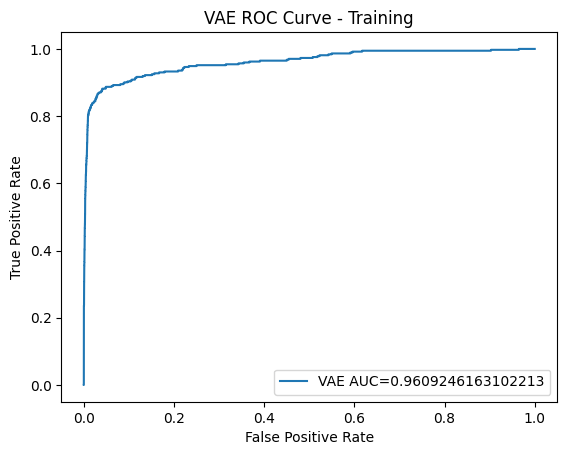

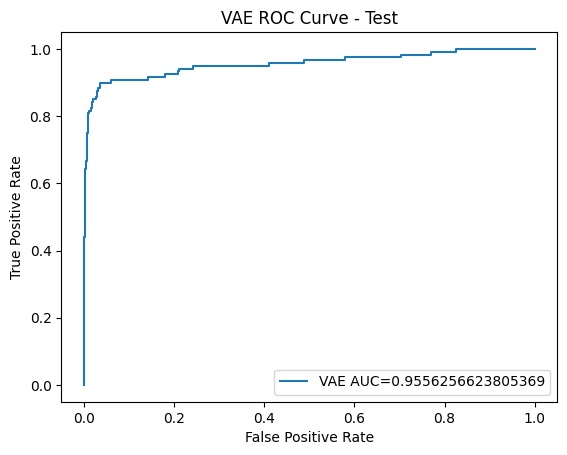

Precision@100: 0.38


In [14]:
############################GELU变分
class GELU(nn.Module):
    def __init__(self):
        super(GELU, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(3.0))

    def forward(self, input):
        temp = input * (1 + torch.erf(input / torch.sqrt(torch.tensor(2.0)) / self.sigma)) / 2
        return temp
# VAE Encoder
class VAEEncoder(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim):
        super(VAEEncoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(input_dim, intermediary_dims1),
            GELU(),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            GELU(),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            GELU()
        )
        self.mean = nn.Linear(intermediary_dims3, latent_dim)
        self.log_var = nn.Linear(intermediary_dims3, latent_dim)
    
    def forward(self, x):
        x = self.fc_layers(x)
        mean = self.mean(x)
        log_var = self.log_var(x)
        return mean, log_var

# VAE Decoder
class VAEDecoder(nn.Module):
    def __init__(self, latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim):
        super(VAEDecoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(latent_dim, intermediary_dims1),
            GELU(),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            GELU(),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            GELU()
        )
        self.output_layer = nn.Linear(intermediary_dims3, output_dim)
    
    def forward(self, z):
        x = self.fc_layers(z)
        return self.output_layer(x)

# VAE Model combining the Encoder and Decoder
class VAE(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim, output_dim):
        super(VAE, self).__init__()
        self.encoder = VAEEncoder(input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim)
        self.decoder = VAEDecoder(latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim)
    
    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterize(mean, log_var)
        reconstructed_x = self.decoder(z)
        return reconstructed_x, mean, log_var

# Initialize model, optimizer, and loss function
model = VAE(input_dim=original_dim, intermediary_dims1=intermediary_dims1, intermediary_dims2=intermediary_dims2,
            intermediary_dims3=intermediary_dims3, latent_dim=latent_dim, output_dim=original_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(max_epochs):
    model.train()
    running_loss = 0.0
    for data in train_loader:
        optimizer.zero_grad()
        data = data[0]  # data is a tuple, we need to extract the tensor
        reconstructed_data, mean, log_var = model(data)
        loss = vae_loss(data, reconstructed_data, mean, log_var)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            data = data[0]
            reconstructed_data, mean, log_var = model(data)
            loss = vae_loss(data, reconstructed_data, mean, log_var)
            val_loss += loss.item()
    
    if epoch % 20 == 0:
        print(f"Epoch {epoch}/{max_epochs}, Training Loss: {running_loss/len(train_loader)}, Validation Loss: {val_loss/len(val_loader)}")

# Calculate log-probabilities for the training data
x_log_prob = reconstruction_log_prob(x)
fpr, tpr, _ = roc_curve(y.numpy(), -x_log_prob.numpy())
auc = roc_auc_score(y.numpy(), -x_log_prob.numpy())

plt.plot(fpr, tpr, label="VAE AUC=" + str(auc))
plt.title('VAE ROC Curve - Training')
plt.ylabel('True Positive Rate')
plt.xlabel("False Positive Rate")
plt.legend(loc='best')
plt.show()

# Calculate log-probabilities for the test data
x_test_log_prob = reconstruction_log_prob(X_test_tensor)
fpr, tpr, _ = roc_curve(test_y, -x_test_log_prob.numpy())
auc = roc_auc_score(test_y, -x_test_log_prob.numpy())

plt.plot(fpr, tpr, label="VAE AUC=" + str(auc))
plt.title('VAE ROC Curve - Test')
plt.ylabel('True Positive Rate')
plt.xlabel("False Positive Rate")
plt.legend(loc='best')
plt.show()

# 计算precision@100
precision_at_100 = evaluate_precision_at_k(model, X_test_tensor, test_y, k=100)
print("Precision@100:", precision_at_100)

Epoch 0/1000, Training Loss: 11870.256467578125, Validation Loss: 4981.574618394207
Epoch 20/1000, Training Loss: 4348.530175390625, Validation Loss: 4304.098527847582
Epoch 40/1000, Training Loss: 4317.37953203125, Validation Loss: 4285.161973309365
Epoch 60/1000, Training Loss: 3665.979340625, Validation Loss: 3639.0967473315586
Epoch 80/1000, Training Loss: 3538.89341875, Validation Loss: 3501.835385462281
Epoch 100/1000, Training Loss: 3403.335708984375, Validation Loss: 3374.5961035467258
Epoch 120/1000, Training Loss: 3363.70470703125, Validation Loss: 3345.185571755573
Epoch 140/1000, Training Loss: 3347.43023671875, Validation Loss: 3320.738794411823
Epoch 160/1000, Training Loss: 3331.782397265625, Validation Loss: 3317.4525869576037
Epoch 180/1000, Training Loss: 3316.438426171875, Validation Loss: 3284.1542782145702
Epoch 200/1000, Training Loss: 3297.662255859375, Validation Loss: 3275.2177703274283
Epoch 220/1000, Training Loss: 3283.08507890625, Validation Loss: 3279.5397

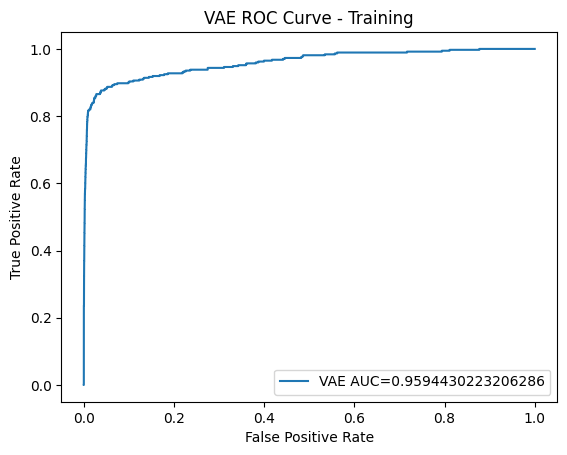

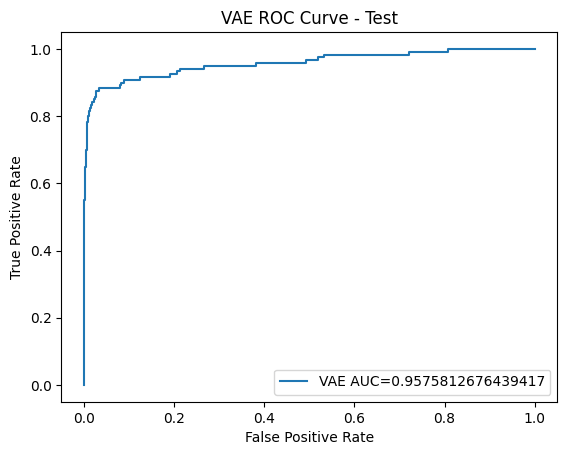

Precision@100: 0.44


In [18]:
############################GELU变分
class SiLU(nn.Module):
    def __init__(self):
        super(SiLU, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(4.0))

    def forward(self, input):
        #temp = input * (1 + torch.erf(input / torch.sqrt(torch.tensor(2.0)) / self.sigma)) / 2
        temp = input * torch.sigmoid(input / self.sigma) # 前向传播
        return temp
# VAE Encoder
class VAEEncoder(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim):
        super(VAEEncoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(input_dim, intermediary_dims1),
            SiLU(),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            SiLU(),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            SiLU()
        )
        self.mean = nn.Linear(intermediary_dims3, latent_dim)
        self.log_var = nn.Linear(intermediary_dims3, latent_dim)
    
    def forward(self, x):
        x = self.fc_layers(x)
        mean = self.mean(x)
        log_var = self.log_var(x)
        return mean, log_var

# VAE Decoder
class VAEDecoder(nn.Module):
    def __init__(self, latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim):
        super(VAEDecoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(latent_dim, intermediary_dims1),
            SiLU(),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            SiLU(),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            SiLU()
        )
        self.output_layer = nn.Linear(intermediary_dims3, output_dim)
    
    def forward(self, z):
        x = self.fc_layers(z)
        return self.output_layer(x)

# VAE Model combining the Encoder and Decoder
class VAE(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim, output_dim):
        super(VAE, self).__init__()
        self.encoder = VAEEncoder(input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim)
        self.decoder = VAEDecoder(latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim)
    
    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterize(mean, log_var)
        reconstructed_x = self.decoder(z)
        return reconstructed_x, mean, log_var

# Initialize model, optimizer, and loss function
model = VAE(input_dim=original_dim, intermediary_dims1=intermediary_dims1, intermediary_dims2=intermediary_dims2,
            intermediary_dims3=intermediary_dims3, latent_dim=latent_dim, output_dim=original_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(max_epochs):
    model.train()
    running_loss = 0.0
    for data in train_loader:
        optimizer.zero_grad()
        data = data[0]  # data is a tuple, we need to extract the tensor
        reconstructed_data, mean, log_var = model(data)
        loss = vae_loss(data, reconstructed_data, mean, log_var)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            data = data[0]
            reconstructed_data, mean, log_var = model(data)
            loss = vae_loss(data, reconstructed_data, mean, log_var)
            val_loss += loss.item()
    
    if epoch % 20 == 0:
        print(f"Epoch {epoch}/{max_epochs}, Training Loss: {running_loss/len(train_loader)}, Validation Loss: {val_loss/len(val_loader)}")

# Calculate log-probabilities for the training data
x_log_prob = reconstruction_log_prob(x)
fpr, tpr, _ = roc_curve(y.numpy(), -x_log_prob.numpy())
auc = roc_auc_score(y.numpy(), -x_log_prob.numpy())

plt.plot(fpr, tpr, label="VAE AUC=" + str(auc))
plt.title('VAE ROC Curve - Training')
plt.ylabel('True Positive Rate')
plt.xlabel("False Positive Rate")
plt.legend(loc='best')
plt.show()

# Calculate log-probabilities for the test data
x_test_log_prob = reconstruction_log_prob(X_test_tensor)
fpr, tpr, _ = roc_curve(test_y, -x_test_log_prob.numpy())
auc = roc_auc_score(test_y, -x_test_log_prob.numpy())

plt.plot(fpr, tpr, label="VAE AUC=" + str(auc))
plt.title('VAE ROC Curve - Test')
plt.ylabel('True Positive Rate')
plt.xlabel("False Positive Rate")
plt.legend(loc='best')
plt.show()

# 计算precision@100
precision_at_100 = evaluate_precision_at_k(model, X_test_tensor, test_y, k=100)
print("Precision@100:", precision_at_100)

Epoch 0/1000, Training Loss: 9106.3824640625, Validation Loss: 4612.449804220989
Epoch 20/1000, Training Loss: 3643.978698828125, Validation Loss: 3582.4010390749404
Epoch 40/1000, Training Loss: 3520.31935, Validation Loss: 3454.5614293578324
Epoch 60/1000, Training Loss: 3453.990006640625, Validation Loss: 3396.60952039585
Epoch 80/1000, Training Loss: 3420.387666015625, Validation Loss: 3367.8500541152466
Epoch 100/1000, Training Loss: 3383.6575421875, Validation Loss: 3342.4120238480295
Epoch 120/1000, Training Loss: 3351.13507734375, Validation Loss: 3305.448151217904
Epoch 140/1000, Training Loss: 3338.346554296875, Validation Loss: 3285.8755582578624
Epoch 160/1000, Training Loss: 3330.44743828125, Validation Loss: 3282.9197344931827
Epoch 180/1000, Training Loss: 3322.822917578125, Validation Loss: 3276.5321775788716
Epoch 200/1000, Training Loss: 3318.002935546875, Validation Loss: 3274.6197253184714
Epoch 220/1000, Training Loss: 3319.062928515625, Validation Loss: 3268.93392

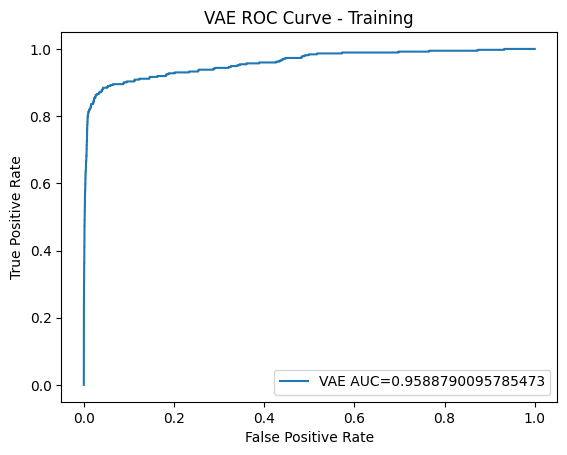

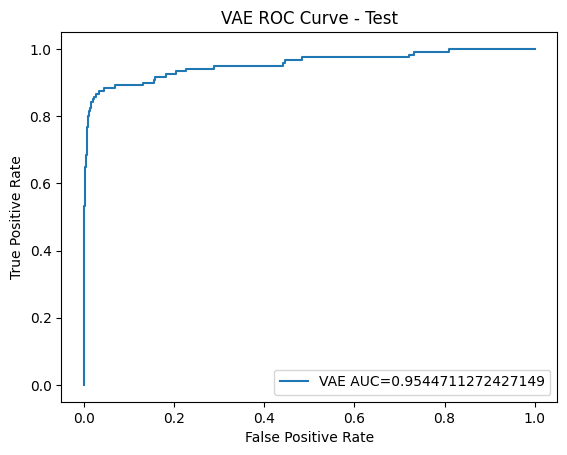

Precision@100: 0.44


In [19]:
############################GELU变分
class RayLU(nn.Module):
    def __init__(self):
        super(RayLU, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(4.0))

    def forward(self, input):
        #temp = input * (1 + torch.erf(input / torch.sqrt(torch.tensor(2.0)) / self.sigma)) / 2
        temp = torch.where(input >= 0, input, input * torch.exp(-input**2 / (2 * self.sigma**2)))
        return temp
# VAE Encoder
class VAEEncoder(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim):
        super(VAEEncoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(input_dim, intermediary_dims1),
            RayLU(),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            RayLU(),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            RayLU()
        )
        self.mean = nn.Linear(intermediary_dims3, latent_dim)
        self.log_var = nn.Linear(intermediary_dims3, latent_dim)
    
    def forward(self, x):
        x = self.fc_layers(x)
        mean = self.mean(x)
        log_var = self.log_var(x)
        return mean, log_var

# VAE Decoder
class VAEDecoder(nn.Module):
    def __init__(self, latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim):
        super(VAEDecoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(latent_dim, intermediary_dims1),
            RayLU(),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            RayLU(),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            RayLU()
        )
        self.output_layer = nn.Linear(intermediary_dims3, output_dim)
    
    def forward(self, z):
        x = self.fc_layers(z)
        return self.output_layer(x)

# VAE Model combining the Encoder and Decoder
class VAE(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim, output_dim):
        super(VAE, self).__init__()
        self.encoder = VAEEncoder(input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim)
        self.decoder = VAEDecoder(latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim)
    
    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterize(mean, log_var)
        reconstructed_x = self.decoder(z)
        return reconstructed_x, mean, log_var

# Initialize model, optimizer, and loss function
model = VAE(input_dim=original_dim, intermediary_dims1=intermediary_dims1, intermediary_dims2=intermediary_dims2,
            intermediary_dims3=intermediary_dims3, latent_dim=latent_dim, output_dim=original_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(max_epochs):
    model.train()
    running_loss = 0.0
    for data in train_loader:
        optimizer.zero_grad()
        data = data[0]  # data is a tuple, we need to extract the tensor
        reconstructed_data, mean, log_var = model(data)
        loss = vae_loss(data, reconstructed_data, mean, log_var)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            data = data[0]
            reconstructed_data, mean, log_var = model(data)
            loss = vae_loss(data, reconstructed_data, mean, log_var)
            val_loss += loss.item()
    
    if epoch % 20 == 0:
        print(f"Epoch {epoch}/{max_epochs}, Training Loss: {running_loss/len(train_loader)}, Validation Loss: {val_loss/len(val_loader)}")

# Calculate log-probabilities for the training data
x_log_prob = reconstruction_log_prob(x)
fpr, tpr, _ = roc_curve(y.numpy(), -x_log_prob.numpy())
auc = roc_auc_score(y.numpy(), -x_log_prob.numpy())

plt.plot(fpr, tpr, label="VAE AUC=" + str(auc))
plt.title('VAE ROC Curve - Training')
plt.ylabel('True Positive Rate')
plt.xlabel("False Positive Rate")
plt.legend(loc='best')
plt.show()

# Calculate log-probabilities for the test data
x_test_log_prob = reconstruction_log_prob(X_test_tensor)
fpr, tpr, _ = roc_curve(test_y, -x_test_log_prob.numpy())
auc = roc_auc_score(test_y, -x_test_log_prob.numpy())

plt.plot(fpr, tpr, label="VAE AUC=" + str(auc))
plt.title('VAE ROC Curve - Test')
plt.ylabel('True Positive Rate')
plt.xlabel("False Positive Rate")
plt.legend(loc='best')
plt.show()

# 计算precision@100
precision_at_100 = evaluate_precision_at_k(model, X_test_tensor, test_y, k=100)
print("Precision@100:", precision_at_100)